In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        super(Autoencoder, self).__init__()
        self.encoder = self._build_layer(input_size, bottleneck_size, hidden_size, layers)
        self.decoder = self._build_layer(bottleneck_size, input_size, hidden_size, layers, reverse=True)

    def _build_layer(self, input_dim, output_dim, hidden_size, layers, reverse=False):
        layer_list = []
        if reverse:
            layer_list.append(nn.Linear(input_dim, hidden_size)) # input_dim is bottleneck_size here
            layer_list.append(nn.ReLU())
            for _ in range(layers - 1):
                layer_list.append(nn.Linear(hidden_size, hidden_size))
                layer_list.append(nn.ReLU())
            layer_list.append(nn.Linear(hidden_size, output_dim))
        else:
            layer_list.append(nn.Linear(input_dim, hidden_size))
            layer_list.append(nn.ReLU())
            for _ in range(layers - 1):
                layer_list.append(nn.Linear(hidden_size, hidden_size))
                layer_list.append(nn.ReLU())
            layer_list.append(nn.Linear(hidden_size, output_dim))
        return nn.Sequential(*layer_list)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
# Generating the two-moons dataset
def generate_moons(noise=0.1, n_samples=1000):
    data, _ = make_moons(n_samples=n_samples, noise=noise)
    return torch.tensor(data, dtype=torch.float32)

In [12]:
# Task 1.1
def train_autoencoder_and_display_tables(hidden_sizes, layer_counts, data, epochs=10, batch_size=64, lr=0.001,
                                         entries_per_table=15, num_columns=2):

    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()

    # Initialize results
    results = {}
    print(f"{'Training Autoencoder with Different Hyperparameters':^80}")
    print("=" * 80)

    for hidden_size in hidden_sizes:
        for layers in layer_counts:
            # Initialize autoencoder
            autoencoder = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=hidden_size, layers=layers)
            optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

            # Training the autoencoder
            for epoch in range(epochs):
                total_loss = 0
                for batch in dataloader:
                    optimizer.zero_grad()
                    reconstructed = autoencoder(batch)
                    loss = criterion(reconstructed, batch)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                avg_loss = total_loss / len(dataloader)

                # Storing results
                if (hidden_size, layers) not in results:
                    results[(hidden_size, layers)] = []
                results[(hidden_size, layers)].append(avg_loss)

    # Flattening results for table formatting
    results_list = [
        (hidden_size, layers, epoch + 1, loss)
        for (hidden_size, layers), losses in results.items()
        for epoch, loss in enumerate(losses)
    ]

    # For Side-by-Side Tables
    chunks = [results_list[i:i + entries_per_table] for i in range(0, len(results_list), entries_per_table)]
    rows = [chunks[i:i + num_columns] for i in range(0, len(chunks), num_columns)]


    for row in rows:
        # Printing headers
        headers = [
            f"{'Hidden Size':<12}{'Layers':<8}{'Epoch':<8}{'Loss':<12}" for _ in row
        ]
        print("    ".join(headers))
        print("    ".join(["-" * 40 for _ in row]))

        for line_idx in range(entries_per_table):
            row_entries = []
            for chunk in row:
                if line_idx < len(chunk):
                    hidden_size, layers, epoch, loss = chunk[line_idx]
                    row_entries.append(f"{hidden_size:<12}{layers:<8}{epoch:<8}{loss:<12.6f}")
                else:
                    row_entries.append(" " * 40)
            print("    ".join(row_entries))

        print("\n")


    return results

# Data to Use
train_data = generate_moons(noise=0.1, n_samples=1000)
hidden_sizes = [16, 32, 64, 128]
layer_counts = [2, 3, 4]

# Training and getting table output
results = train_autoencoder_and_display_tables(
    hidden_sizes=hidden_sizes,
    layer_counts=layer_counts,
    data=train_data,
    epochs=10,
    batch_size=64,
    lr=0.001,
    entries_per_table=15,
    num_columns=2
)


              Training Autoencoder with Different Hyperparameters               
Hidden Size Layers  Epoch   Loss            Hidden Size Layers  Epoch   Loss        
----------------------------------------    ----------------------------------------
16          2       1       0.573079        16          3       6       0.268988    
16          2       2       0.523311        16          3       7       0.177801    
16          2       3       0.481891        16          3       8       0.132862    
16          2       4       0.441213        16          3       9       0.115392    
16          2       5       0.385944        16          3       10      0.104500    
16          2       6       0.297998        16          4       1       0.776662    
16          2       7       0.184192        16          4       2       0.698536    
16          2       8       0.114100        16          4       3       0.649236    
16          2       9       0.097424        16          4       4    

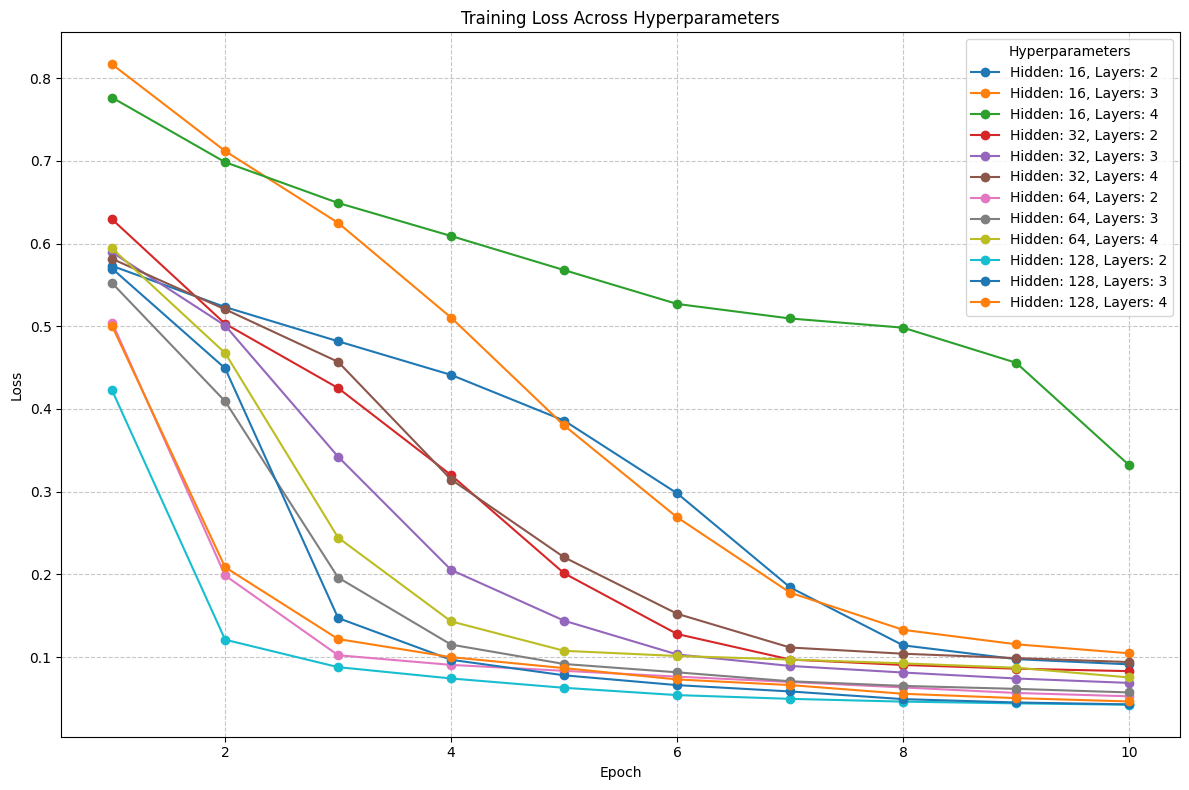

In [13]:
# Function to compare the loss across different Hyperparameters
def plot_loss_results(results):
    plt.figure(figsize=(12, 8))
    for (hidden_size, layers), losses in results.items():
        plt.plot(range(1, len(losses) + 1), losses, marker='o', label=f"Hidden: {hidden_size}, Layers: {layers}")

    plt.title("Training Loss Across Hyperparameters")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(title="Hyperparameters", loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


plot_loss_results(results)

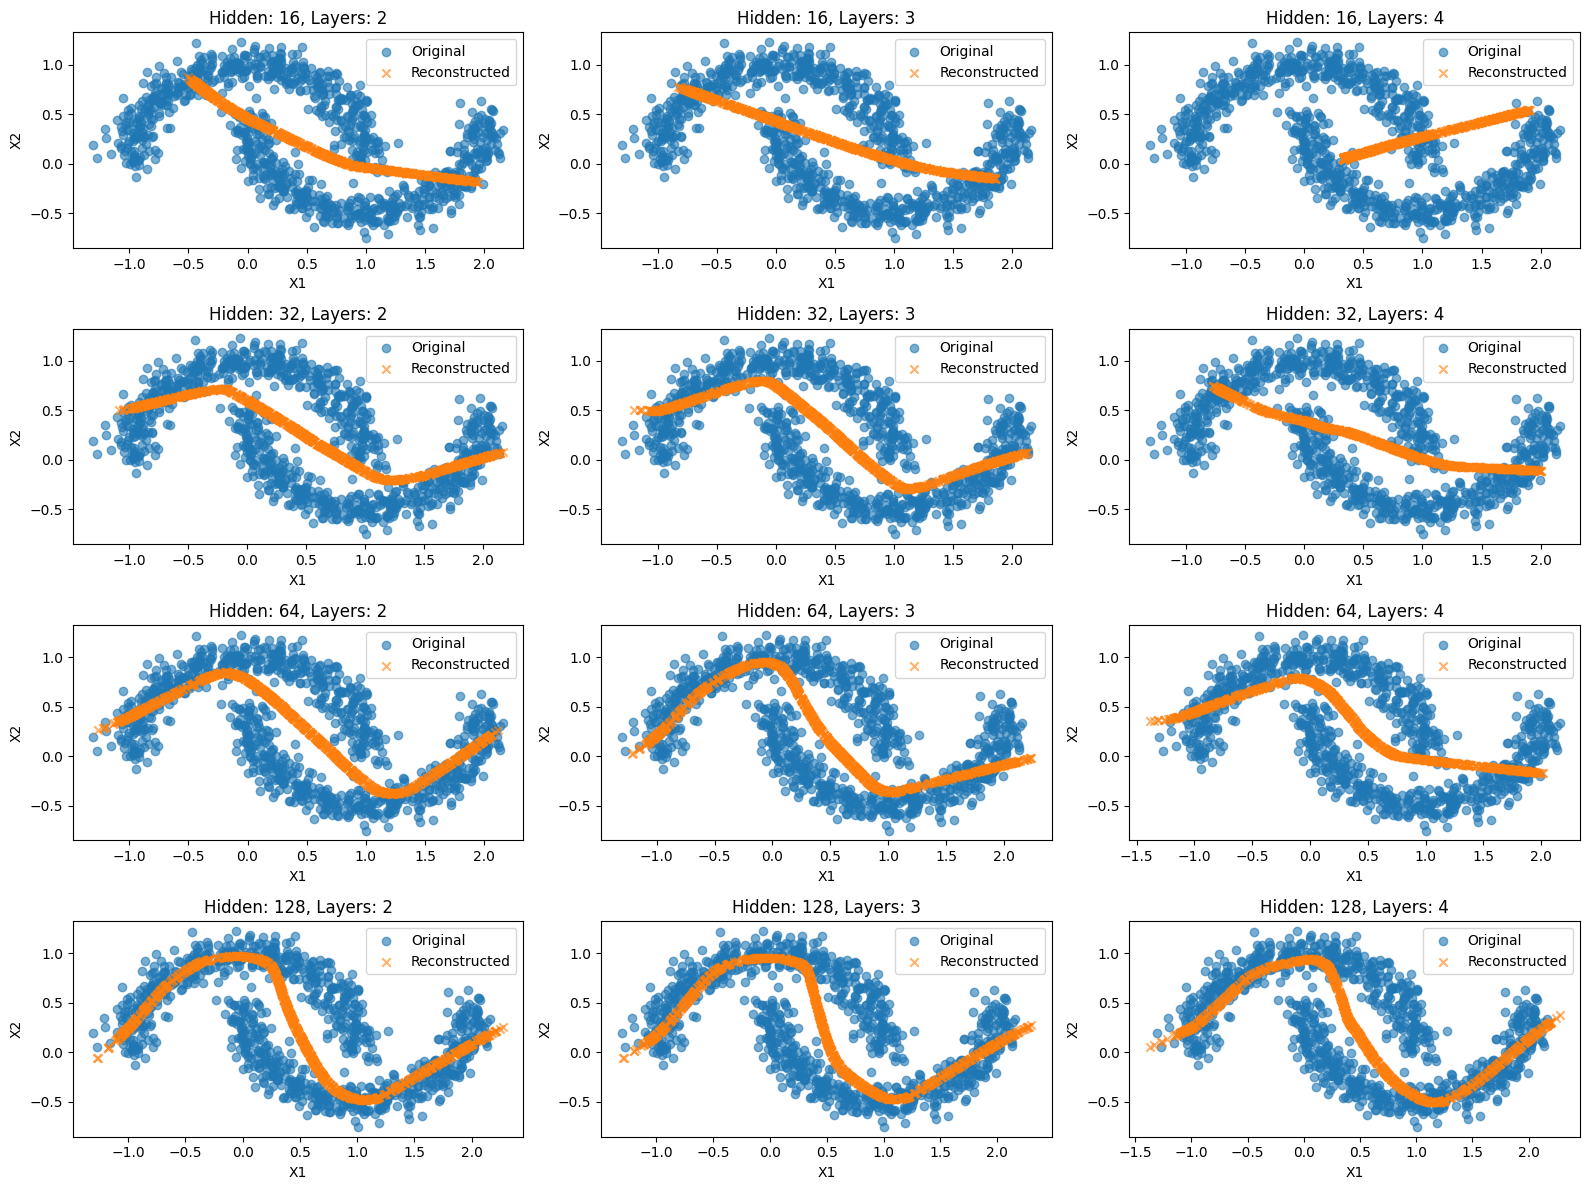

In [14]:
# Task 1.1
def plot_reconstructed_vs_original(data, hidden_sizes, layer_counts, epochs=10, batch_size=64, lr=0.001):

    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)
    original_points = data

    plt.figure(figsize=(16, 12))
    plot_idx = 1

    # Iterating over hyperparameter combinations
    for hidden_size in hidden_sizes:
        for layers in layer_counts:

            autoencoder = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=hidden_size, layers=layers)
            optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
            criterion = nn.MSELoss()

            # Training the Autoencoder
            autoencoder.train()
            for epoch in range(epochs):
                for batch in dataloader:
                    optimizer.zero_grad()
                    reconstructed = autoencoder(batch)
                    loss = criterion(reconstructed, batch)
                    loss.backward()
                    optimizer.step()

            autoencoder.eval()
            with torch.no_grad():
                reconstructed_points = autoencoder(original_points)

            # Plot
            plt.subplot(len(hidden_sizes), len(layer_counts), plot_idx)
            plt.scatter(original_points[:, 0], original_points[:, 1], alpha=0.6, label="Original")
            plt.scatter(reconstructed_points[:, 0], reconstructed_points[:, 1], alpha=0.6, label="Reconstructed", marker='x')
            plt.title(f"Hidden: {hidden_size}, Layers: {layers}")
            plt.xlabel("X1")
            plt.ylabel("X2")
            plt.legend()
            plot_idx += 1

    plt.tight_layout()
    plt.show()

# Calling the function using the previous values
plot_reconstructed_vs_original(
    data=generate_moons(noise=0.1, n_samples=1000),
    hidden_sizes = [16, 32, 64, 128],
    layer_counts = [2, 3, 4],
    epochs=10,
    batch_size=64,
    lr=0.001
)

Investigating variations with SAME dataset:
Run 1: Reconstruction Error (MSE) = 0.039125
Run 2: Reconstruction Error (MSE) = 0.040010
Run 3: Reconstruction Error (MSE) = 0.039477
Run 4: Reconstruction Error (MSE) = 0.036619
Run 5: Reconstruction Error (MSE) = 0.038802

Investigating variations with DIFFERENT datasets:
Run 1: Reconstruction Error (MSE) = 0.038915
Run 2: Reconstruction Error (MSE) = 0.043215
Run 3: Reconstruction Error (MSE) = 0.037828
Run 4: Reconstruction Error (MSE) = 0.036323
Run 5: Reconstruction Error (MSE) = 0.038195


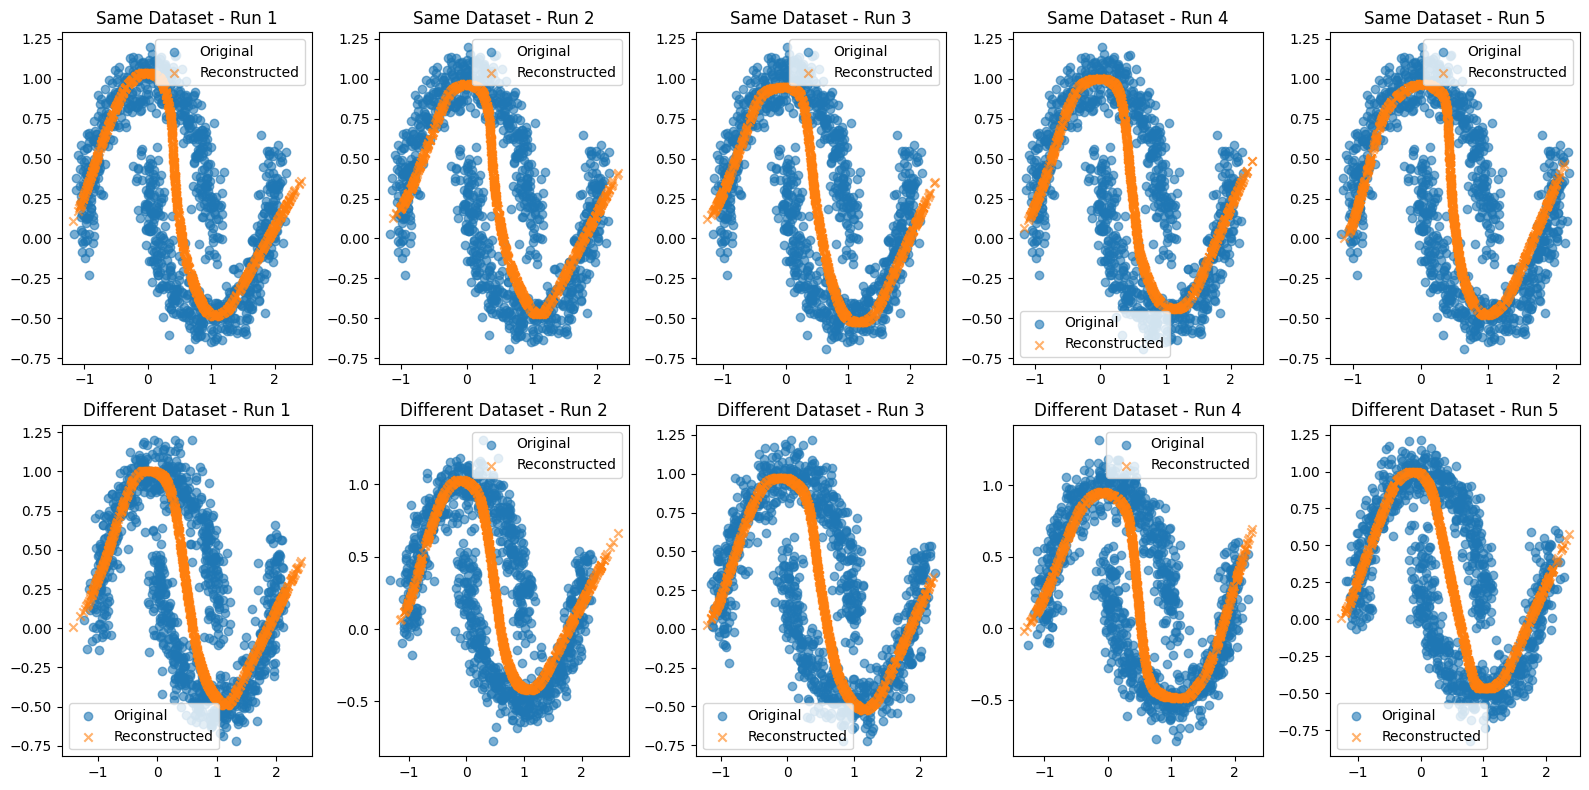


Summary of Reconstruction Errors:
Run     Same Dataset MSE    Different Dataset MSE
----------------------------------------
1       0.039125            0.038915            
2       0.040010            0.043215            
3       0.039477            0.037828            
4       0.036619            0.036323            
5       0.038802            0.038195            


In [15]:
# Task 1.2
def reconstruction_variation(best_hidden_size, best_layers, noise_level=0.1, epochs=10, batch_size=64, lr=0.001, runs=5):
    criterion = nn.MSELoss()

    # Reconstructing same dataset
    original_data = generate_moons(noise=noise_level, n_samples=1000)
    dataloader = torch.utils.data.DataLoader(original_data, batch_size=batch_size, shuffle=True)

    print("Investigating variations with SAME dataset:")
    same_dataset_errors = []
    same_dataset_reconstructions = []

    for run in range(runs):
        autoencoder = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=best_hidden_size, layers=best_layers)
        optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

        # Training
        autoencoder.train()
        for epoch in range(epochs):
            for batch in dataloader:
                optimizer.zero_grad()
                reconstructed = autoencoder(batch)
                loss = criterion(reconstructed, batch)
                loss.backward()
                optimizer.step()

        # Error calculation
        autoencoder.eval()
        with torch.no_grad():
            reconstructed_points = autoencoder(original_data)
            mse = criterion(reconstructed_points, original_data).item()
            same_dataset_errors.append(mse)
            same_dataset_reconstructions.append(reconstructed_points)

        print(f"Run {run + 1}: Reconstruction Error (MSE) = {mse:.6f}")

    # Different dataset reconstruction
    print("\nInvestigating variations with DIFFERENT datasets:")
    diff_dataset_errors = []
    diff_dataset_reconstructions = []

    for run in range(runs):
        # Generating a new dataset for each run
        different_data = generate_moons(noise=noise_level, n_samples=1000)
        dataloader = torch.utils.data.DataLoader(different_data, batch_size=batch_size, shuffle=True)

        autoencoder = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=best_hidden_size, layers=best_layers)
        optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

        # Train
        autoencoder.train()
        for epoch in range(epochs):
            for batch in dataloader:
                optimizer.zero_grad()
                reconstructed = autoencoder(batch)
                loss = criterion(reconstructed, batch)
                loss.backward()
                optimizer.step()

        # Error calculation
        autoencoder.eval()
        with torch.no_grad():
            reconstructed_points = autoencoder(different_data)
            mse = criterion(reconstructed_points, different_data).item()
            diff_dataset_errors.append(mse)
            diff_dataset_reconstructions.append(reconstructed_points)

        print(f"Run {run + 1}: Reconstruction Error (MSE) = {mse:.6f}")

    # Ploting for same dataset
    plt.figure(figsize=(16, 8))
    for i in range(runs):
        plt.subplot(2, runs, i + 1)
        plt.scatter(original_data[:, 0], original_data[:, 1], alpha=0.6, label="Original")
        plt.scatter(same_dataset_reconstructions[i][:, 0], same_dataset_reconstructions[i][:, 1], alpha=0.6, label="Reconstructed", marker='x')
        plt.title(f"Same Dataset - Run {i + 1}")
        plt.legend()

    # Ploting for different datasets
    for i in range(runs):
        plt.subplot(2, runs, runs + i + 1)
        different_data = generate_moons(noise=noise_level, n_samples=1000)
        plt.scatter(different_data[:, 0], different_data[:, 1], alpha=0.6, label="Original")
        plt.scatter(diff_dataset_reconstructions[i][:, 0], diff_dataset_reconstructions[i][:, 1], alpha=0.6, label="Reconstructed", marker='x')
        plt.title(f"Different Dataset - Run {i + 1}")
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Summary
    print("\nSummary of Reconstruction Errors:")
    print(f"{'Run':<8}{'Same Dataset MSE':<20}{'Different Dataset MSE'}")
    print("-" * 40)
    for i in range(runs):
        print(f"{i + 1:<8}{same_dataset_errors[i]:<20.6f}{diff_dataset_errors[i]:<20.6f}")

# Using the function for best parameter setting
reconstruction_variation(
    best_hidden_size=128,
    best_layers=3,
    noise_level=0.1,
    epochs=10,
    batch_size=64,
    lr=0.001,
    runs=5
)

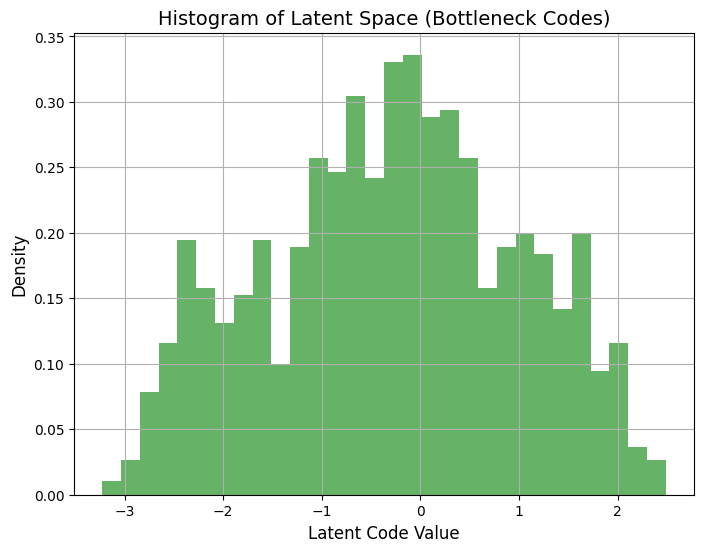

In [16]:
# Task 1.3

# Taking the best hyperparameter for autoencoder
autoencoder = Autoencoder(input_size=2, bottleneck_size=1, hidden_size=128, layers=2)

# Taking the data again
original_data = generate_moons(noise=0.1, n_samples=1000)
dataloader = torch.utils.data.DataLoader(original_data, batch_size=64, shuffle=True)

# Adam Optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(10):
    for batch in dataloader:
        optimizer.zero_grad()
        reconstructed = autoencoder(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()

autoencoder.eval()
latent_codes = []

with torch.no_grad():
    for batch in dataloader:

        codes = autoencoder.encoder(batch)
        latent_codes.append(codes.numpy())


latent_codes = np.vstack(latent_codes)

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(latent_codes, bins=30, density=True, alpha=0.6, color='g')
plt.title('Histogram of Latent Space (Bottleneck Codes)', fontsize=14)
plt.xlabel('Latent Code Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.show()

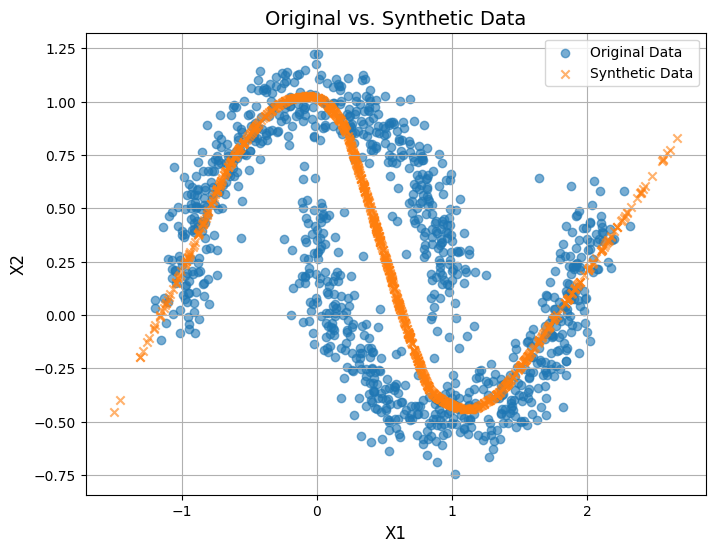

In [17]:
# Fitting Gaussian Mixture Model (GMM) to Latent Space
gmm = GaussianMixture(n_components=2)
gmm.fit(latent_codes)

# Sample synthetic data from GMM
n_samples = 1000
sampled_codes = gmm.sample(n_samples)[0]

synthetic_data = autoencoder.decoder(torch.tensor(sampled_codes, dtype=torch.float32))

plt.figure(figsize=(8, 6))
plt.scatter(original_data[:, 0], original_data[:, 1], alpha=0.6, label="Original Data")
plt.scatter(synthetic_data.detach().numpy()[:, 0],
            synthetic_data.detach().numpy()[:, 1],
            alpha=0.6, label="Synthetic Data", marker='x')
plt.title('Original vs. Synthetic Data', fontsize=14)
plt.xlabel('X1', fontsize=12)
plt.ylabel('X2', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Reconstruction Error (MSE) on noisy test set (noise=0.2): 0.059952


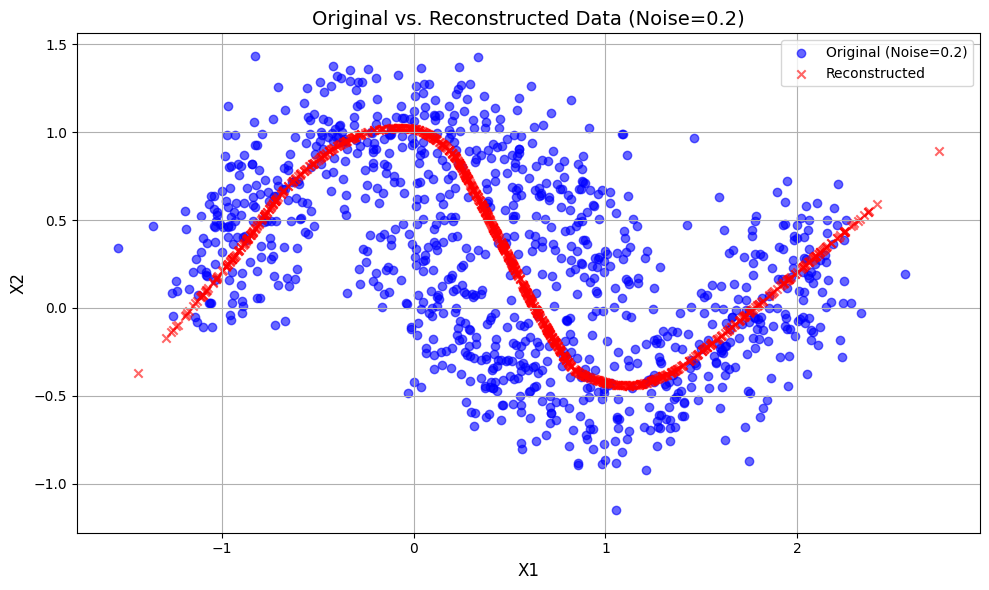

In [20]:
# Task 1.4-1.5
# Taking a new test set with noise level 0.2
test_data = generate_moons(noise=0.2, n_samples=1000)

autoencoder.eval()

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# Collecting reconstructed data
reconstructed_data = []
with torch.no_grad():
    for batch in test_dataloader:
        reconstructed = autoencoder(batch)
        reconstructed_data.append(reconstructed)

reconstructed_data = torch.cat(reconstructed_data, dim=0).numpy()

# Calculating MSE between original test data and reconstructed data
mse = mean_squared_error(test_data, reconstructed_data)
print(f"Reconstruction Error (MSE) on noisy test set (noise=0.2): {mse:.6f}")

plt.figure(figsize=(10, 6))

plt.scatter(test_data[:, 0], test_data[:, 1], alpha=0.6, label="Original (Noise=0.2)", color='blue')

plt.scatter(reconstructed_data[:, 0], reconstructed_data[:, 1], alpha=0.6, label="Reconstructed", marker='x', color='red')

plt.title("Original vs. Reconstructed Data (Noise=0.2)", fontsize=14)
plt.xlabel("X1", fontsize=12)
plt.ylabel("X2", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()